# Code required to generate Figure 2. 
Note that the code in 01_Prepare Data should be run before this. This figure will differ slightly from the one presented in the paper as it is run using the sample data (due to file size constraints) uploaded to the online repository. The full raw data is available on request from the authors.

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interpn

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib.patches import Arc, Rectangle
from matplotlib.transforms import ScaledTranslation, blended_transform_factory
import seaborn as sns

from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.stats import gmean, spearmanr
import scienceplots

plt.style.use("high-contrast")
colours = ["C0", "C1", "C2"]

import statsmodels.api as sm
import statsmodels.formula.api as smf

import patato as pat

from paiskintonetools import setup_matplotlib, get_example_scan_of_type
from paiskintonetools.stats import p_formatter, loess_bootstrap, LinearRegDiagnostic

from pathlib import Path

from functools import partial

setup_matplotlib(dpi=300)
plt.rcParams["figure.constrained_layout.use"] = False

custom_transform = lambda x, y=0: ScaledTranslation(-x / 4, -y / 4, fig.dpi_scale_trans)


def get_lineplot(rec, roi, delta=0.001):
    xs = rec.da.coords["z"].values
    ys = rec.da.coords["x"].values
    d = np.linspace(-delta, delta, 100)

    x0, y0 = np.array(roi.get_polygon().centroid.xy).flatten()
    points = np.stack([np.ones_like(d) * x0, d + y0]).T
    return d * 1000, interpn((xs, ys), np.squeeze(rec.raw_data).T, points), points

In [2]:
def agg_function(x, npf=np.nanmean):
    if np.issubdtype(x.dtype, np.number):
        return npf(x)
    elif hasattr(x.iloc[0], "dtype"):
        # Assume that this is a numpy array.
        return npf(np.stack(x), axis=0)
    else:
        return x.iloc[0]

In [3]:
root_data_path = Path("../Data")

In [4]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [5]:
df_data_all_points = pd.read_parquet("../01_Prepare Data/pa_values_extracted_all_meta.parquet")


def query_and_aggregate(region, roi, df_data=df_data_all_points):
    df_data = df_data.query(
        f"(Region == '{region}') and (`OtherDetail` == '') and \
               (`ROI Name` == '{roi}') and (Parallel == '')"
    )

    # First, average over the three scans taken per patient
    df_data_all = (
        df_data.groupby(["SkinID", "RunNumber", "Side", "Pigment"])
        .agg(agg_function)
        .reset_index()
    )

    # For CoV, remove Vitiligo cohort
    df_data_all_cov = df_data_all.query("`Fitzpatrick Type` != 'Vitiligo'")
    # For coefficient of variation etc...
    m = df_data_all_cov.groupby(["SkinID", "ITA", "Fitzpatrick Type"]).agg(
        {"spectrum_positive_mean": partial(agg_function, npf=np.nanmean)}
    )
    s = df_data_all_cov.groupby(["SkinID", "ITA", "Fitzpatrick Type"]).agg(
        {"spectrum_positive_mean": partial(agg_function, npf=np.nanstd)}
    )
    cov = (
        s["spectrum_positive_mean"] / m["spectrum_positive_mean"].apply(np.abs)
    ).reset_index()
    cov = cov.rename(columns={"spectrum_positive_mean": "spectrum_cov"})
    cov["spectrum_std"] = pd.Series(dtype=object)
    for i, row in s["spectrum_positive_mean"].reset_index(drop=True).items():
        cov["spectrum_std"].at[i] = row

    df_data = df_data_all.groupby("SkinID").agg(agg_function).reset_index()
    return df_data, cov

In [6]:
region = "Radial Artery"
roi = "artery"
df_data, cov = query_and_aggregate(region, roi)

region = "Bicep"
roi = "muscle"
df_data_bicep, cov_bicep = query_and_aggregate(region, roi)

In [7]:
df_radiomics = pd.read_parquet(
    "intermediate data/radiomics_texture_analysis_radial_artery.parquet"
)
df_radiomics = (
    df_radiomics.groupby(["SkinID", "Wavelength"])
    .median(numeric_only=True)
    .reset_index()
)

df_radiomics_bicep = pd.read_parquet(
    "intermediate data/radiomics_texture_analysis_bicep_muscle.parquet"
)
df_radiomics_bicep = (
    df_radiomics_bicep.groupby(["SkinID", "Wavelength"])
    .median(numeric_only=True)
    .reset_index()
)

In [8]:
wavelengths = np.array(sorted(pd.unique(df_radiomics["Wavelength"])))
wavelengths_to_plot = [700, 800, 1080]
wavelengths_to_visualise = [700, 1080]

In [9]:
df_ita = df_data[["SkinID", "ITA", "Fitzpatrick Type"]]
df_radiomics = df_radiomics.merge(df_ita, on="SkinID")

df_ita_bicep = df_data_bicep[["SkinID", "ITA", "Fitzpatrick Type"]]
df_radiomics_bicep = df_radiomics_bicep.merge(df_ita_bicep, on="SkinID")

In [10]:
itas = df_ita
itas = itas.sort_values("ITA").reset_index()
index_to_use = np.linspace(0, itas.shape[0]-1, 6).astype(int)[::-1]

index_to_use[1] += 1  # Choose slightly nicer scans - doesn't affect conclusions!
index_to_use[3] += 1  # Choose a nice looking scan
index_to_use[2] += 2  # Choose a nice looking scan
examples = itas[["SkinID", "ITA"]].iloc[index_to_use].reset_index(drop=True)

N observtions: 33.0
Mean value (Radial Artery, 700) vs ITA: p = 0.80873!!Positive!!
N observtions: 33.0
Mean value (Radial Artery, 800) vs ITA: p = 0.16352!!Positive!!
N observtions: 33.0
Mean value (Radial Artery, 1080) vs ITA: p = 0.35369!!Positive!!
N observtions: 35.0
Mean value (Bicep, 700) vs ITA: p = 0.00000
N observtions: 35.0
Mean value (Bicep, 800) vs ITA: p = 0.00000
N observtions: 35.0
Mean value (Bicep, 1080) vs ITA: p = 0.00191
Standard deviation (Radial Artery, 700) vs ITA: p = 0.05140
Standard deviation (Radial Artery, 800) vs ITA: p = 0.29376!!Positive!!
Standard deviation (Radial Artery, 1080) vs ITA: p = 0.62195!!Positive!!
Standard deviation (Bicep, 700) vs ITA: p = 0.00000
Standard deviation (Bicep, 800) vs ITA: p = 0.00000
Standard deviation (Bicep, 1080) vs ITA: p = 0.08785


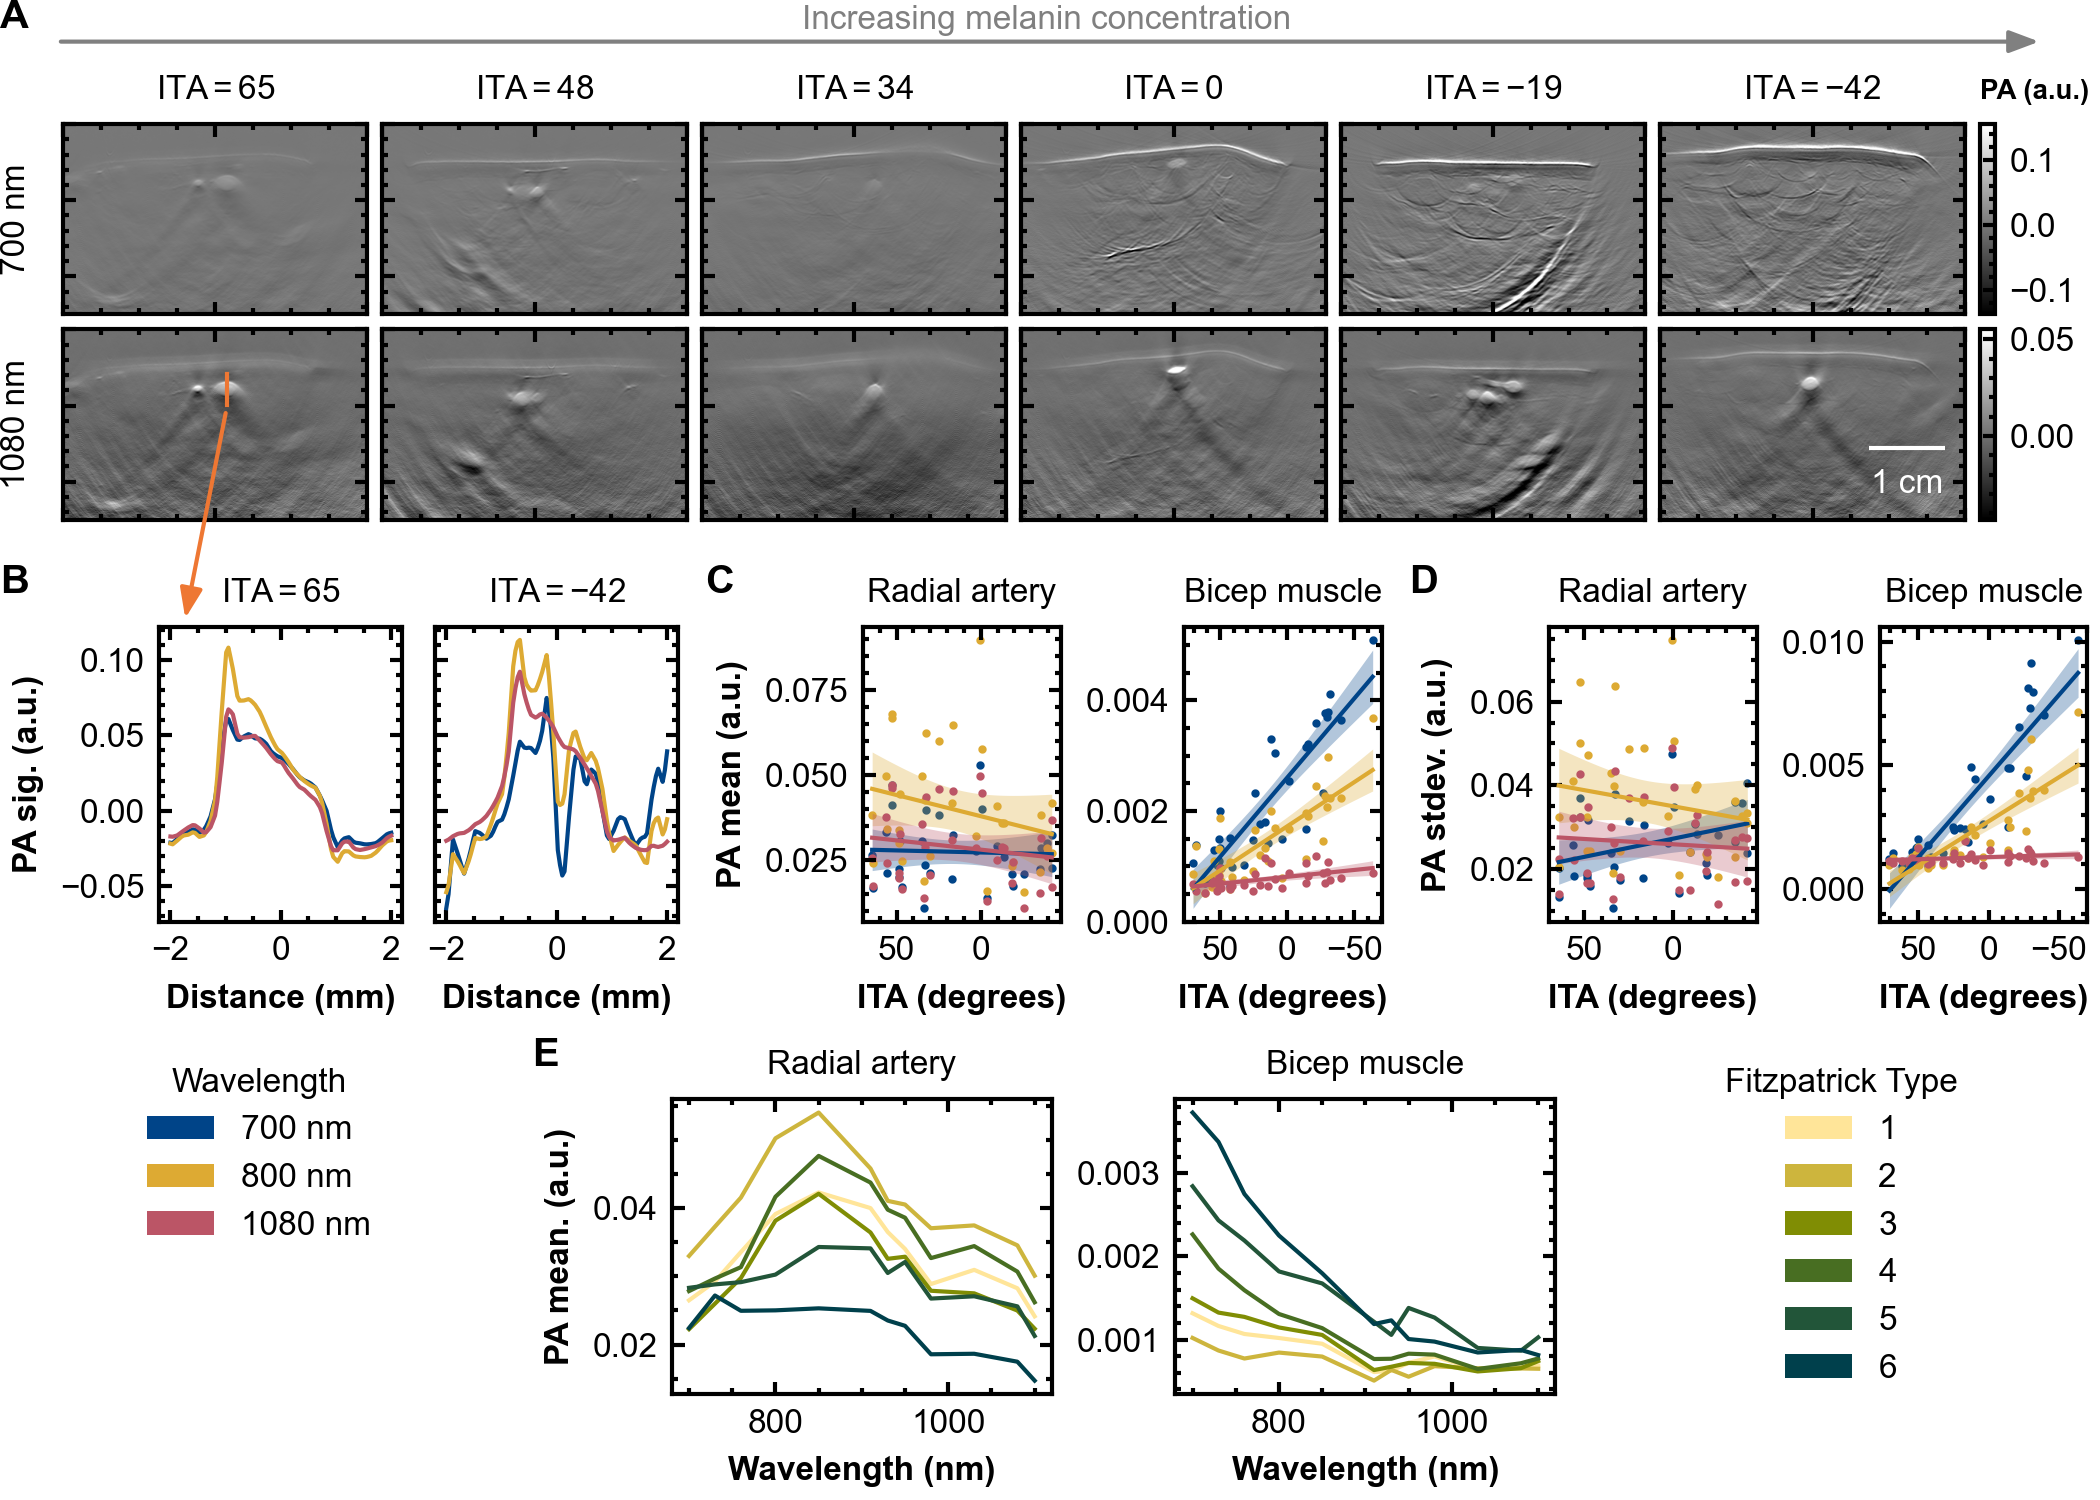

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(7, 5))

subfigs = fig.subfigures(3, height_ratios=[1.5, 1.25, 1.25])

# subfigs_diagrams, subfigs_ultrasound = subfigs[0].subfigures(1, 2)
# subfigs_diagrams.text(
#     0, 1, "A", va="top", ha="left", fontsize="large", fontweight="bold"
# )
legend_subfigure2, subfiglower_2, legend_subfigure = subfigs[2].subfigures(
    1, 3, width_ratios=[1, 2, 1]
)
subfig_lineplots, subfig_quantification, subfiglower_1 = subfigs[1].subfigures(1, 3)
axes_lineplots = subfig_lineplots.subplots(
    1, 2, gridspec_kw=dict(wspace=0.0), sharex=True, sharey=True
)

subfigs[0].text(0, 1, "A", va="top", ha="left", fontsize="large", fontweight="bold")

# 0.29 to 0.89 has the image grid. So crop it down to 0.75 of original height.
# 0.29 becomes 0.053
# 0.89 becomes 0.853
# Arrow should move too probably:
#

axes_images = ImageGrid(
    subfigs[0],
    (0.03, 0.02, 0.92, 0.8),  # similar to subplot(111)
    nrows_ncols=(len(wavelengths_to_visualise), 6),  # creates 2x2 grid of Axes
    axes_pad=0.05,  # pad between Axes in inch.
    share_all=True,
    label_mode="all",
    cbar_mode="edge",
)
axes_images[0].set_ylim([-0.015, 0.01])
axes_images[0].set_xlim([-0.02, 0.02])
for ax in axes_images:
    ax.yaxis.set_tick_params(labelleft=False)
    ax.xaxis.set_tick_params(labelbottom=False)

asb = AnchoredSizeBar(
    axes_images[-1].transData,
    0.01,
    "1 cm",
    loc="lower right",
    pad=0.1,
    borderpad=0.5,
    sep=5,
    frameon=False,
    color="white",
)
axes_images[-1].add_artist(asb)
axes_images.cbar_axes[0].set_title(
    "PA (a.u.)", fontsize="small", loc="left", fontweight="bold"
)

ims = np.empty((6, len(wavelengths_to_visualise)), dtype=object)
for i in range(6):
    ita = examples.loc[i, "ITA"]
    title = r"$\mathdefault{ITA = " + f"{ita:.0f}" + "}$"
    axes_images[i].set_title(title, fontsize="medium", fontweight="normal")
    skin_id_to_show = examples.loc[i, "SkinID"]
    pa = pat.PAData.from_hdf5(
        get_example_scan_of_type(root_data_path / skin_id_to_show, "forearm")
    )
    assert "parallel" not in pa.get_scan_name()
    rec = pa.get_scan_reconstructions()["Model Based", "0"]
    xs = rec.da.coords["x"].values
    extent = rec.extent
    pa_weighting = np.exp(xs / 0.0075)
    for j, wl in enumerate(wavelengths_to_visualise):
        n_wl = np.argmin(np.abs(wl - pa.get_wavelengths()))
        ims[i, j] = axes_images[i + j * 6].imshow(
            rec.raw_data[0, n_wl, 50:300, 0] / pa_weighting[50:300, None],
            extent=(-0.02, 0.02, -0.015, 0.01),
            origin="lower",
            cmap="gray",
        )
    if i in [0, 5]:
        axindex = [0, 5].index(i)
        # Make line plots of the radial artery:
        for j, wl in enumerate(wavelengths_to_plot):
            wl_index = np.argmin(np.abs(wl - pa.get_wavelengths()))
            roi, delta = ("artery_", "0"), 0.002
            x, y, points = get_lineplot(
                rec[:, wl_index], pa.get_rois()[roi], delta=delta
            )
            if j == 1 and i == 0:
                axes_images[6].plot(points[:, 0], points[:, 1], color="#EE7733")
                axes_images[6].annotate(
                    "",
                    (0.1, 1),
                    points[0],
                    xycoords=axes_lineplots[0].transAxes,
                    textcoords=axes_images[6].transData,
                    arrowprops=dict(
                        arrowstyle="-|>,head_width=.15",
                        mutation_scale=15,
                        color="#EE7733",
                    ),
                )
            axes_lineplots[axindex].plot(x[::-1], y, c=colours[j], label=f"{wl:.0f} nm")

# assert 1 == 2

handles, labels = axes_lineplots[0].get_legend_handles_labels()
new_handles = []
for h in handles:
    new_handles.append(
        mpatches.Rectangle(
            (0, 0), 1 / 4, 1 / 4, facecolor=h.get_color(), transform=fig.dpi_scale_trans
        )
    )

legend_subfigure2.legend(new_handles, labels, title="Wavelength", loc="upper center")

for i in range(len(wavelengths_to_visualise)):
    # Set the clims for wavelengths
    clims = [[], []]
    for im in ims[:, i]:
        clims[0].append(im.get_clim()[0])
        clims[1].append(im.get_clim()[1])
    for im in ims[:, i]:
        im.set_clim((np.mean(clims[0]), gmean(clims[1])))
    axes_images.cbar_axes[i].colorbar(ims[0, i])

for j, wl in enumerate(wavelengths_to_visualise):
    axes_images[6 * j].set_ylabel(
        f"{wl:.0f} nm", fontweight="normal", fontsize="medium"
    )

axes_lineplots[0].set_ylabel("PA sig. (a.u.)")
axes_lineplots[0].set_xlabel("Distance (mm)")
axes_lineplots[1].set_xlabel("Distance (mm)")
title = r"$\mathdefault{ITA = " + f"{examples.loc[0, 'ITA']:.0f}" + "}$"
axes_lineplots[0].set_title(title, fontsize="medium", fontweight="normal")
title = r"$\mathdefault{ITA = " + f"{examples.loc[5, 'ITA']:.0f}" + "}$"
axes_lineplots[1].set_title(title, fontsize="medium", fontweight="normal")
# subfig_lineplots.set_facecolor("red")
subfig_lineplots.text(
    0, 1, "B", va="top", ha="left", fontsize="large", fontweight="bold"
)

ax1, ax2 = subfig_quantification.subplots(1, 2)
ax1.set_title("Radial artery", fontweight="normal", fontsize="medium")
ax2.set_title("Bicep muscle", fontweight="normal", fontsize="medium")
ax1.set_xlabel("ITA (degrees)")
ax2.set_xlabel("ITA (degrees)")
ax1.set_ylabel("PA mean (a.u.)")

region_names = ["Radial Artery", "Bicep"]
for dataset, ax, region_labels in zip(
    [df_data, df_data_bicep], [ax1, ax2], region_names
):
    # Plot signal vs ITA for:
    for i, wl_plot in enumerate(wavelengths_to_plot):
        wl_index = np.where(wavelengths == wl_plot)[0][0]
        dataset["ToPlot"] = dataset["spectrum_positive_mean"].apply(
            lambda x: x[wl_index]
        )
        ax.scatter(dataset["ITA"], dataset["ToPlot"], color=colours[i], s=1)
        ita_plot = pd.DataFrame(
            {"ITA": np.linspace(np.min(dataset["ITA"]), np.max(dataset["ITA"]))}
        )

        md = smf.ols("ToPlot ~ ITA", dataset)  #
        print("N observtions:", md.nobs)
        mdf = md.fit()
        p = mdf.pvalues["ITA"]

        print(
            f"Mean value ({region_labels}, {wl_plot:.0f}) vs ITA: p = {p:.5f}"
            + ("!!Positive!!" if mdf.params["ITA"] > 0 else "")
        )
        ita_plot = pd.concat(
            [ita_plot, mdf.get_prediction(ita_plot).summary_frame()], axis=1
        )
        ax.plot(
            ita_plot["ITA"],
            ita_plot["mean"],
            color=colours[i],
            label=f"{wl_plot:.0f} nm",
        )
        ax.fill_between(
            ita_plot["ITA"],
            ita_plot["mean_ci_lower"],
            ita_plot["mean_ci_upper"],
            color=colours[i],
            alpha=0.3,
            linewidth=0,
        )

    ax.invert_xaxis()
subfig_quantification.text(
    0, 1, "C", va="top", ha="left", fontsize="large", fontweight="bold"
)


arr = mpatches.FancyArrowPatch(
    (0.025, 0.925),
    (0.975, 0.925),
    arrowstyle="-|>,head_width=.15",
    mutation_scale=15,
    transform=subfigs[0].transSubfigure,
    clip_on=False,
    color="gray",
)
axes_images[0].add_patch(arr)
axes_images[0].annotate(
    "Increasing melanin concentration",
    (0.5, 0.8),
    xycoords=arr,
    ha="center",
    va="bottom",
    color="gray",
)
from palettable.scientific.sequential import Bamako_6_r

fp_colours = Bamako_6_r.mpl_colors
fp_colours = dict([(str(i), fp_colours[i - 1]) for i in range(1, 7)])
fp_colours["Vitiligo"] = "gray"

axes = subfiglower_2.subplots(1, 2)

i = 0
for ax, df_data_to_plot in zip(axes, [df_data, df_data_bicep]):
    for n, g in df_data_to_plot.groupby("Fitzpatrick Type"):
        spec = np.median(np.stack(g["spectrum_positive_mean"]), axis=0)[:-1]
        ax.plot(
            pa.get_wavelengths()[:-1],
            spec,
            color=fp_colours[n],
            label=f"{n}" if i == 0 else None,
        )
    i += 1

handles, labels = axes[0].get_legend_handles_labels()
new_handles = []
for h in handles:
    new_handles.append(
        mpatches.Rectangle(
            (0, 0), 1 / 4, 1 / 4, facecolor=h.get_color(), transform=fig.dpi_scale_trans
        )
    )

legend_subfigure.legend(
    new_handles, labels, title="Fitzpatrick Type", loc="upper center"
)
# subfiglower_2.legend(loc="outside right", title="Fitz.\nType", fontsize="small")

axes[0].set_xlabel("Wavelength (nm)")
axes[1].set_xlabel("Wavelength (nm)")
axes[0].set_ylabel("PA mean. (a.u.)")
axes[0].set_title("Radial artery", fontsize="medium", fontweight="normal")
axes[1].set_title("Bicep muscle", fontsize="medium", fontweight="normal")

# Subfigure for the standard deviation plots.
axes = subfiglower_1.subplots(1, 2)

region_names = ["Radial Artery", "Bicep"]
for df_plot, ax, region_labels in zip([df_data, df_data_bicep], axes, region_names):
    for j, wl in enumerate(wavelengths_to_plot):
        wl_index = np.argmin(np.abs(wl - pa.get_wavelengths()))
        df_plot["ToPlot"] = df_plot["spectrum_std"].apply(lambda x: x[wl_index])
        ax.scatter(df_plot["ITA"], df_plot["ToPlot"], s=1)

        ita_plot = pd.DataFrame(
            {"ITA": np.linspace(np.min(df_plot["ITA"]), np.max(df_plot["ITA"]))}
        )
        md = smf.ols("ToPlot ~ ITA", df_plot)  #
        mdf = md.fit()
        p = mdf.pvalues["ITA"]

        print(
            f"Standard deviation ({region_labels}, {wl:.0f}) vs ITA: p = {p:.5f}"
            + ("!!Positive!!" if mdf.params["ITA"] > 0 else "")
        )
        ita_plot = pd.concat(
            [ita_plot, mdf.get_prediction(ita_plot).summary_frame()], axis=1
        )
        ax.plot(
            ita_plot["ITA"],
            ita_plot["mean"],
            color=colours[j],
        )
        ax.fill_between(
            ita_plot["ITA"],
            ita_plot["mean_ci_lower"],
            ita_plot["mean_ci_upper"],
            color=colours[j],
            alpha=0.3,
            linewidth=0,
        )

axes[0].invert_xaxis()
axes[1].invert_xaxis()
axes[0].set_xlabel("ITA (degrees)")
axes[1].set_xlabel("ITA (degrees)")
axes[0].set_ylabel("PA stdev. (a.u.)")

axes[0].set_title("Radial artery", fontsize="medium", fontweight="normal")
axes[1].set_title("Bicep muscle", fontsize="medium", fontweight="normal")

subfiglower_2.text(0, 1, "E", va="top", ha="left", fontsize="large", fontweight="bold")
subfiglower_1.text(0, 1, "D", va="top", ha="left", fontsize="large", fontweight="bold")

fig.savefig("figures/figure2.pdf", dpi=300)
fig.savefig("figures/figure2.svg", dpi=300)
plt.show()

In [12]:
# Todo: make an equivalent plot to A for the muscles for the supplementary.
# Todo: Make a supplementary figure where we try and quantify the clutter (sd - 1080).

## Reproducibility analysis:

This code can only be run with the full dataset. Due to file size constraints, this is only available on request from the authors. The code below is provided for completeness nonetheless.

RA ITA < median COV mean 0.0
RA ITA > median COV mean 0.0
Bicep ITA < median COV mean 0.0
Bicep ITA > median COV mean 0.0


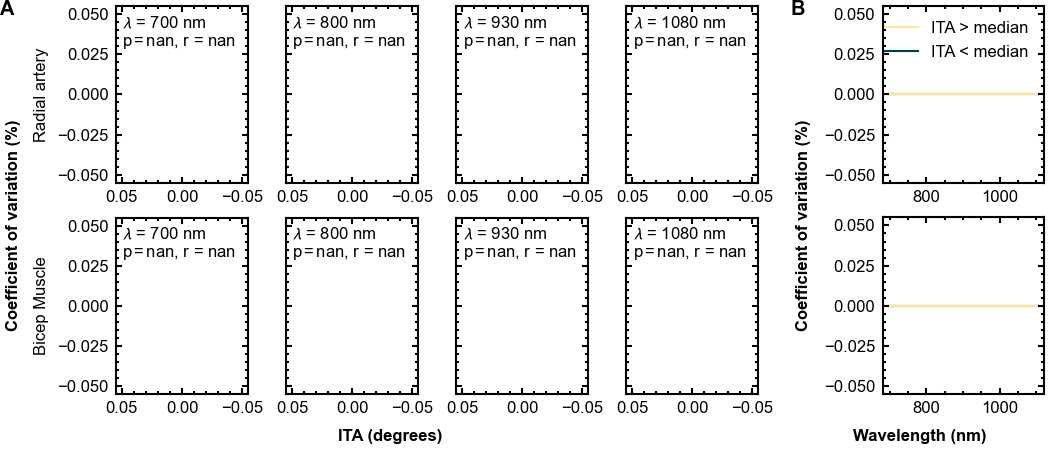

In [13]:
# Suppress warnings - this is because the sample dataset does not include repeats and so cannot be computed here.
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(7, 3), dpi=150, constrained_layout=True)

subfiga, subfigb = fig.subfigures(1, 2, width_ratios=[3, 1])
axes = subfiga.subplots(2, 4, sharex="row", sharey="row")

wavelengths = pa.get_wavelengths()
pvalues = []
rvalues = []
wavelengths_to_show = [700, 800, 930, 1080]

for axrow, cov_data in zip(axes, [cov, cov_bicep]):
    cov_data = cov_data[
        cov_data["spectrum_cov"].apply(lambda x: not np.all(x == 0))
    ].reset_index()
    for ax, wl in zip(axrow, wavelengths_to_show):
        i = np.argmin(np.abs(wl - wavelengths))
        cov_data["cov_single_wavelength"] = (
            cov_data["spectrum_cov"].apply(lambda x: x[i]) * 100
        )
        ax.scatter(cov_data["ITA"], cov_data["cov_single_wavelength"], s=5, c="k")

        X, Y, Ymax, Ymin = loess_bootstrap(
            cov_data["ITA"],
            cov_data["cov_single_wavelength"],
            frac=0.66666,
            it=1,
            n_bootstrap=100,
        )
        l = ax.plot(X, Y, label="LOESS", c="k")
        ax.fill_between(X, Ymin, Ymax, alpha=0.3, facecolor=l[0].get_color())

        # test = smf.ols("cov_single_wavelength~ITA + Gender",cov_data)
        # testfit = test.fit()

        # # if testfit.pvalues["ITA"] < 0.05:
        #     # LinearRegDiagnostic(testfit)()
        #     # print(wl, testfit.pvalues["ITA"])

        pr = spearmanr(cov_data["ITA"], cov_data["cov_single_wavelength"])
        pvalues.append(pr.pvalue)
        rvalues.append(pr.statistic)
    axrow[0].invert_xaxis()

i = 0
for axrow in axes:
    for ax, wl in zip(axrow, wavelengths_to_show):
        pvalue = pvalues[i]
        statistic = rvalues[i]
        ax.text(
            0.05,
            0.95,
            f"$\\lambda$ = {wl:.0f} nm \n"
            + p_formatter(pvalue)
            + f", r = {statistic:.2f}",
            c="k",
            transform=ax.transAxes,
            va="top",
            ha="left",
        )
        i += 1
axes[0, 0].set_ylabel("Radial artery", fontweight="normal")
axes[1, 0].set_ylabel("Bicep Muscle", fontweight="normal")

# axes[0, 0].set_ylim([0, min(100, axes[0, 0].get_ylim()[1])])
# axes[1, 0].set_ylim([0, min(100, axes[1, 0].get_ylim()[1])])

subfiga.supylabel("Coefficient of variation (%)", fontsize="medium", fontweight="bold")

subfiga.supxlabel("ITA (degrees)", fontsize="medium", fontweight="bold")

axes = subfigb.subplots(2)
subfigb.supxlabel("Wavelength (nm)", fontsize="medium", fontweight="bold")
subfigb.supylabel("Coefficient of variation (%)", fontsize="medium", fontweight="bold")


from palettable.scientific.sequential import Bamako_6_r

fp_colours = Bamako_6_r.mpl_colors

i = 0
for df_plot, ax in zip([cov, cov_bicep], axes):
    df_plot["Fitzpatrick Group"] = df_plot["ITA"] > np.median(df_plot["ITA"])
    for fp, g in df_plot.iloc[2:].groupby("Fitzpatrick Group"):
        print(
            "Bicep" if i == 1 else "RA",
            "ITA > median" if fp else "ITA < median",
            "COV mean",
            100 * np.nanmean(np.stack(g["spectrum_cov"])),
        )
        ax.plot(
            wavelengths[:-1],
            100 * np.nanmean(np.stack(g["spectrum_cov"]), axis=0)[:-1],
            label="ITA > median" if fp else "ITA < median",
            c=fp_colours[0] if fp else fp_colours[-1],
        )
    i += 1
axes[0].legend(reverse=True)

subfiga.text(0, 1, "A", va="top", ha="left", fontsize="large", fontweight="bold")
subfigb.text(0, 1, "B", va="top", ha="left", fontsize="large", fontweight="bold")
fig.savefig("figures/coefficient_of_variation_wavelength.pdf", dpi=300)
fig.savefig("figures/coefficient_of_variation_wavelength.svg", dpi=300)
plt.show()

In [14]:
itas = df_ita_bicep
itas = itas[itas["Fitzpatrick Type"] != "Vitiligo"]
itas = itas.sort_values("ITA").reset_index()
index_to_use = np.linspace(0, itas.shape[0]-1, 6).astype(int)[::-1]
index_to_use[1] += 1  # Skin13 is to be avoided...
# index_to_use[3] += 1  # Choose a nice looking scan
index_to_use[2] += 1  # Choose a nice looking scan
index_to_use[-2] -= 1
index_to_use[-1] += 2
examples = itas[["SkinID", "ITA"]].iloc[index_to_use].reset_index(drop=True)

In [ ]:
fig = plt.figure(constrained_layout=False, figsize=(7, 2.5))

axes_images = ImageGrid(
    fig,
    (0.03, 0.005, 0.9, 0.9),  # similar to subplot(111)
    nrows_ncols=(len(wavelengths_to_visualise) + 1, 6),  # creates 2x2 grid of Axes
    axes_pad=0.05,  # pad between Axes in inch.
    share_all=True,
    label_mode="all",
    cbar_mode="edge",
)
axes_images[0].set_ylim([-0.015, 0.01])
axes_images[0].set_xlim([-0.02, 0.02])
for ax in axes_images:
    ax.yaxis.set_tick_params(labelleft=False)
    ax.xaxis.set_tick_params(labelbottom=False)

asb = AnchoredSizeBar(
    axes_images[-1].transData,
    0.01,
    "1 cm",
    loc="lower right",
    pad=0.1,
    borderpad=0.5,
    sep=5,
    frameon=False,
    color="white",
)
axes_images[-1].add_artist(asb)
axes_images.cbar_axes[0].set_title(
    "PA (a.u.)", fontsize="small", loc="left", fontweight="bold"
)

ims = np.empty((6, len(wavelengths_to_visualise) + 1), dtype=object)
for i in range(6):
    ita = examples.loc[i, "ITA"]
    title = r"$\mathdefault{ITA = " + f"{ita:.0f}" + "}$"
    axes_images[i].set_title(title, fontsize="medium", fontweight="normal")
    skin_id_to_show = examples.loc[i, "SkinID"]
    pa = pat.PAData.from_hdf5(
        get_example_scan_of_type(root_data_path / skin_id_to_show, "bicep")
    )
    assert "parallel" not in pa.get_scan_name()
    rec = pa.get_scan_reconstructions()["Model Based", "0"]
    xs = rec.da.coords["x"].values
    extent = rec.extent
    pa_weighting = np.exp(xs / 0.0075)
    for j, wl in enumerate(wavelengths_to_visualise + ["US"]):
        if wl != "US":
            n_wl = np.argmin(np.abs(wl - pa.get_wavelengths()))
            ims[i, j] = axes_images[i + j * 6].imshow(
                rec.raw_data[0, n_wl, 50:300, 0] / pa_weighting[50:300, None],
                extent=(-0.02, 0.02, -0.015, 0.01),
                origin="lower",
                cmap="gray",
            )
        else:
            ims[i, j] = axes_images[i + j * 6].imshow(
                pa.get_ultrasound().raw_data[0, 0, :, 0],
                extent=(-0.02, 0.02, -0.02, 0.02),
                origin="lower",
                cmap="bone",
            )

for i in range(len(wavelengths_to_visualise) + 1):
    # Set the clims for wavelengths
    clims = [[], []]
    for im in ims[:, i]:
        clims[0].append(im.get_clim()[0])
        clims[1].append(im.get_clim()[1])
    for im in ims[:, i]:
        im.set_clim((np.mean(clims[0]), gmean(clims[1])))
    axes_images.cbar_axes[i].colorbar(ims[0, i])

for j, wl in enumerate(wavelengths_to_visualise + ["US"]):
    if wl != "US":
        axes_images[6 * j].set_ylabel(
            f"{wl:.0f} nm", fontweight="normal", fontsize="medium"
        )
    else:
        axes_images[6 * j].set_ylabel(
            f"Ultrasound", fontweight="normal", fontsize="medium"
        )

arr = mpatches.FancyArrowPatch(
    (0.025, 0.95),
    (0.975, 0.95),
    arrowstyle="-|>,head_width=.15",
    mutation_scale=15,
    transform=fig.transSubfigure,
    clip_on=False,
    color="gray",
)
axes_images[0].add_patch(arr)
axes_images[0].annotate(
    "Increasing melanin concentration",
    (0.5, 0.8),
    xycoords=arr,
    ha="center",
    va="bottom",
    color="gray",
)
plt.savefig("figures/example_images_bicep.pdf", dpi=300)
plt.savefig("figures/example_images_bicep.svg", dpi=300)
plt.show()

In [ ]:
region = "Leg"
roi = "muscle"
df_data_leg, _ = query_and_aggregate(region, roi)

itas = df_data_leg.query("`Fitzpatrick Type` != 'Vitiligo'")
itas = itas.sort_values("ITA").reset_index()
index_to_use = np.linspace(0, itas.shape[0]-1, 6).astype(int)[::-1]
index_to_use[1] += 1  # Skin13 is to be avoided...
index_to_use[3] += 1  # Choose a nice looking scan
index_to_use[2] += 2  # Choose a nice looking scan
index_to_use[-1] += 1
examples = itas[["SkinID", "ITA"]].iloc[index_to_use].reset_index(drop=True)

In [ ]:
fig = plt.figure(constrained_layout=False, figsize=(7, 2.5))

axes_images = ImageGrid(
    fig,
    (0.03, 0.005, 0.9, 0.9),  # similar to subplot(111)
    nrows_ncols=(len(wavelengths_to_visualise) + 1, 6),  # creates 2x2 grid of Axes
    axes_pad=0.05,  # pad between Axes in inch.
    share_all=True,
    label_mode="all",
    cbar_mode="edge",
)
axes_images[0].set_ylim([-0.015, 0.01])
axes_images[0].set_xlim([-0.02, 0.02])
for ax in axes_images:
    ax.yaxis.set_tick_params(labelleft=False)
    ax.xaxis.set_tick_params(labelbottom=False)

asb = AnchoredSizeBar(
    axes_images[-1].transData,
    0.01,
    "1 cm",
    loc="lower right",
    pad=0.1,
    borderpad=0.5,
    sep=5,
    frameon=False,
    color="white",
)
axes_images[-1].add_artist(asb)
axes_images.cbar_axes[0].set_title(
    "PA (a.u.)", fontsize="small", loc="left", fontweight="bold"
)

ims = np.empty((6, len(wavelengths_to_visualise) + 1), dtype=object)
for i in range(6):
    ita = examples.loc[i, "ITA"]
    title = r"$\mathdefault{ITA = " + f"{ita:.0f}" + "}$"
    axes_images[i].set_title(title, fontsize="medium", fontweight="normal")
    skin_id_to_show = examples.loc[i, "SkinID"]
    pa = pat.PAData.from_hdf5(
        get_example_scan_of_type(root_data_path / skin_id_to_show, "leg")
    )
    assert "parallel" not in pa.get_scan_name()
    rec = pa.get_scan_reconstructions()["Model Based", "0"]
    xs = rec.da.coords["x"].values
    extent = rec.extent
    pa_weighting = np.exp(xs / 0.0075)
    for j, wl in enumerate(wavelengths_to_visualise + ["US"]):
        if wl != "US":
            n_wl = np.argmin(np.abs(wl - pa.get_wavelengths()))
            ims[i, j] = axes_images[i + j * 6].imshow(
                rec.raw_data[0, n_wl, 50:300, 0] / pa_weighting[50:300, None],
                extent=(-0.02, 0.02, -0.015, 0.01),
                origin="lower",
                cmap="gray",
            )
        else:
            ims[i, j] = axes_images[i + j * 6].imshow(
                pa.get_ultrasound().raw_data[0, 0, :, 0],
                extent=(-0.02, 0.02, -0.02, 0.02),
                origin="lower",
                cmap="bone",
            )

for i in range(len(wavelengths_to_visualise) + 1):
    # Set the clims for wavelengths
    clims = [[], []]
    for im in ims[:, i]:
        clims[0].append(im.get_clim()[0])
        clims[1].append(im.get_clim()[1])
    for im in ims[:, i]:
        im.set_clim((np.mean(clims[0]), gmean(clims[1])))
    axes_images.cbar_axes[i].colorbar(ims[0, i])

for j, wl in enumerate(wavelengths_to_visualise + ["US"]):
    if wl != "US":
        axes_images[6 * j].set_ylabel(
            f"{wl:.0f} nm", fontweight="normal", fontsize="medium"
        )
    else:
        axes_images[6 * j].set_ylabel(
            f"Ultrasound", fontweight="normal", fontsize="medium"
        )

arr = mpatches.FancyArrowPatch(
    (0.025, 0.95),
    (0.975, 0.95),
    arrowstyle="-|>,head_width=.15",
    mutation_scale=15,
    transform=fig.transSubfigure,
    clip_on=False,
    color="gray",
)
axes_images[0].add_patch(arr)
axes_images[0].annotate(
    "Increasing melanin concentration",
    (0.5, 0.8),
    xycoords=arr,
    ha="center",
    va="bottom",
    color="gray",
)
plt.savefig("figures/example_images_leg.pdf", dpi=300)
plt.savefig("figures/example_images_leg.svg", dpi=300)
plt.show()

In [ ]:
region = "Carotid Artery"
roi = "artery"
df_data_leg, _ = query_and_aggregate(region, roi)

itas = df_data_leg.query("`Fitzpatrick Type` != 'Vitiligo'")
itas = itas.sort_values("ITA").reset_index()
index_to_use = np.linspace(0, itas.shape[0]-1, 6).astype(int)[::-1]
index_to_use[1] += 1  # Skin13 is to be avoided...
index_to_use[3] += 1  # Choose a nice looking scan
index_to_use[2] += 2  # Choose a nice looking scan
index_to_use[-1] += 0
examples = itas[["SkinID", "ITA"]].iloc[index_to_use].reset_index(drop=True)
examples

In [ ]:
fig = plt.figure(constrained_layout=False, figsize=(7, 2.5))

axes_images = ImageGrid(
    fig,
    (0.03, 0.005, 0.9, 0.9),  # similar to subplot(111)
    nrows_ncols=(len(wavelengths_to_visualise) + 1, 6),  # creates 2x2 grid of Axes
    axes_pad=0.05,  # pad between Axes in inch.
    share_all=True,
    label_mode="all",
    cbar_mode="edge",
)
axes_images[0].set_ylim([-0.015, 0.01])
axes_images[0].set_xlim([-0.02, 0.02])
for ax in axes_images:
    ax.yaxis.set_tick_params(labelleft=False)
    ax.xaxis.set_tick_params(labelbottom=False)

asb = AnchoredSizeBar(
    axes_images[-1].transData,
    0.01,
    "1 cm",
    loc="lower right",
    pad=0.1,
    borderpad=0.5,
    sep=5,
    frameon=False,
    color="white",
)
axes_images[-1].add_artist(asb)
axes_images.cbar_axes[0].set_title(
    "PA (a.u.)", fontsize="small", loc="left", fontweight="bold"
)

ims = np.empty((6, len(wavelengths_to_visualise) + 1), dtype=object)
for i in range(6):
    ita = examples.loc[i, "ITA"]
    title = r"$\mathdefault{ITA = " + f"{ita:.0f}" + "}$"
    axes_images[i].set_title(title, fontsize="medium", fontweight="normal")
    skin_id_to_show = examples.loc[i, "SkinID"]
    pa = pat.PAData.from_hdf5(
        get_example_scan_of_type(root_data_path / skin_id_to_show, "neck")
    )
    assert "parallel" not in pa.get_scan_name()
    rec = pa.get_scan_reconstructions()["Model Based", "0"]
    xs = rec.da.coords["x"].values
    extent = rec.extent
    pa_weighting = np.exp(xs / 0.0075)
    for j, wl in enumerate(wavelengths_to_visualise + ["US"]):
        if wl != "US":
            n_wl = np.argmin(np.abs(wl - pa.get_wavelengths()))
            ims[i, j] = axes_images[i + j * 6].imshow(
                rec.raw_data[0, n_wl, 50:300, 0] / pa_weighting[50:300, None],
                extent=(-0.02, 0.02, -0.015, 0.01),
                origin="lower",
                cmap="gray",
            )
        else:
            ims[i, j] = axes_images[i + j * 6].imshow(
                pa.get_ultrasound().raw_data[0, 0, :, 0],
                extent=(-0.02, 0.02, -0.02, 0.02),
                origin="lower",
                cmap="bone",
            )

for i in range(len(wavelengths_to_visualise) + 1):
    # Set the clims for wavelengths
    clims = [[], []]
    for im in ims[:, i]:
        clims[0].append(im.get_clim()[0])
        clims[1].append(im.get_clim()[1])
    for im in ims[:, i]:
        im.set_clim((np.mean(clims[0]), gmean(clims[1])))
    axes_images.cbar_axes[i].colorbar(ims[0, i])

for j, wl in enumerate(wavelengths_to_visualise + ["US"]):
    if wl != "US":
        axes_images[6 * j].set_ylabel(
            f"{wl:.0f} nm", fontweight="normal", fontsize="medium"
        )
    else:
        axes_images[6 * j].set_ylabel(
            f"Ultrasound", fontweight="normal", fontsize="medium"
        )

arr = mpatches.FancyArrowPatch(
    (0.025, 0.95),
    (0.975, 0.95),
    arrowstyle="-|>,head_width=.15",
    mutation_scale=15,
    transform=fig.transSubfigure,
    clip_on=False,
    color="gray",
)
axes_images[0].add_patch(arr)
axes_images[0].annotate(
    "Increasing melanin concentration",
    (0.5, 0.8),
    xycoords=arr,
    ha="center",
    va="bottom",
    color="gray",
)

plt.savefig("figures/example_images_neck.pdf", dpi=300)
plt.savefig("figures/example_images_neck.svg", dpi=300)
plt.show()